In [1]:
!pip install tensorflow
!pip install cuda-python

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

2024-02-20 03:20:43.710712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 03:20:43.711004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 03:20:43.724429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 03:20:43.747987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 03:20:46.016845: W tensorflow/compiler/tf2

In [3]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, walk_through_dir, pred_and_plot

In [4]:
dataset = "../../SmartBin/data/raw_data/Dataset"
walk_through_dir(dataset)

There are 3 directories and 0 images in '../../SmartBin/data/raw_data/Dataset'.
There are 0 directories and 697 images in '../../SmartBin/data/raw_data/Dataset/trash'.
There are 0 directories and 865 images in '../../SmartBin/data/raw_data/Dataset/plastic'.
There are 0 directories and 775 images in '../../SmartBin/data/raw_data/Dataset/white-glass'.


In [5]:
# Đường dẫn đến thư mục chứa dataset
data_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(data_dir.glob(r'**/*.JPG')) + list(data_dir.glob(r'**/*.jpg')) + list(data_dir.glob(r'**/*.png')) + list(data_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df

,Filepath,Label
0,../../SmartBin/data/raw_data/Dataset/trash/tra...,trash
1,../../SmartBin/data/raw_data/Dataset/trash/tra...,trash
2,../../SmartBin/data/raw_data/Dataset/trash/tra...,trash
3,../../SmartBin/data/raw_data/Dataset/trash/tra...,trash
4,../../SmartBin/data/raw_data/Dataset/trash/tra...,trash
...,...,...
2332,../../SmartBin/data/raw_data/Dataset/white-gla...,white-glass
2333,../../SmartBin/data/raw_data/Dataset/white-gla...,white-glass
2334,../../SmartBin/data/raw_data/Dataset/white-gla...,white-glass
2335,../../SmartBin/data/raw_data/Dataset/white-gla...,white-glass


[1378  749  878  817  930  894 1238 1928  558 1857 1922 2124 1368 1046
  789   15]


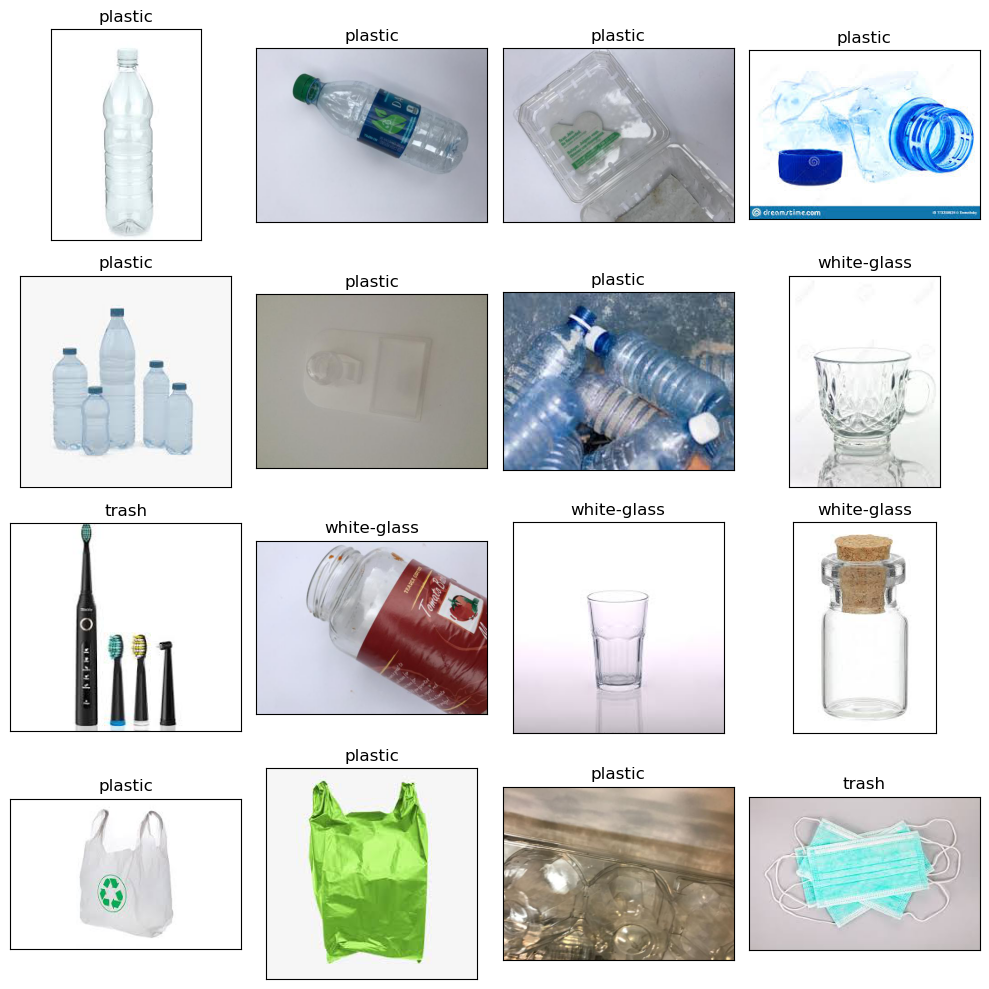

In [7]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

train_df.shape

test_df.shape

train_generator = ImageDataGenerator(
rescale=1./255,
validation_split=0.2
)

test_generator = ImageDataGenerator(
rescale=1./255
)

In [8]:
import os

# Định nghĩa các tham số cho dataset
batch_size = 32
img_size = (200, 200)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(img_size[0], img_size[1]),
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=True,
seed=42,
subset='training'
)

val_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(img_size[0], img_size[1]),
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=True,
seed=42,
subset='validation'
)

test_images = test_generator.flow_from_dataframe(
dataframe=test_df,
x_col='Filepath',
y_col='Label',
target_size=(img_size[0], img_size[1]),
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=False
)

Found 1496 validated image filenames belonging to 3 classes.
Found 373 validated image filenames belonging to 3 classes.
Found 468 validated image filenames belonging to 3 classes.


In [9]:
model = models.Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(200, 200, 3))),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2, 2)),
model.add(Conv2D(128, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(256, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(512, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(1024, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Flatten()),
model.add(Dense(1024, activation='relu')),
model.add(BatchNormalization()),
model.add(Dense(3, activation='softmax'))

2024-02-20 03:20:50.597714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 03:20:50.597984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 03:20:50.667202: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

In [10]:
# Compile the model
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [11]:
# Set up callbacks
checkpoint_path = '../models/checkpoints/cnn_model_checkpoint.ckpt'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
save_weights_only=True,
save_best_only=True,
monitor='val_accuracy',
verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_loss',
patience=10)

In [12]:
# Train the model
history = model.fit(train_images,
steps_per_epoch=len(train_images),
epochs=10,
validation_data=val_images,
validation_steps=len(val_images),
callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/10


2024-02-20 03:20:52.023535: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2024-02-20 03:20:52.053959: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


47/47 [==============================] - ETA: 0s - loss: 1.7463 - accuracy: 0.5461
Epoch 1: val_accuracy improved from -inf to 0.30563, saving model to ../models/checkpoints/cnn_model_checkpoint.ckpt
47/47 [==============================] - 299s 6s/step - loss: 1.7463 - accuracy: 0.5461 - val_loss: 2.6212 - val_accuracy: 0.3056
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 0.7994 - accuracy: 0.6324
Epoch 2: val_accuracy improved from 0.30563 to 0.33780, saving model to ../models/checkpoints/cnn_model_checkpoint.ckpt
47/47 [==============================] - 389s 8s/step - loss: 0.7994 - accuracy: 0.6324 - val_loss: 1.3166 - val_accuracy: 0.3378
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.7000 - accuracy: 0.6985
Epoch 3: val_accuracy did not improve from 0.33780
47/47 [==============================] - 428s 9s/step - loss: 0.7000 - accuracy: 0.6985 - val_loss: 1.2205 - val_accuracy: 0.3271
Epoch 4/10
47/47 [==============================] -

In [13]:
test_loss, test_accuracy = model.evaluate(test_images, steps=len(test_images))
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

15/15 [==============================] - 11s 723ms/step - loss: 0.7673 - accuracy: 0.6581
Test loss: 0.7673084735870361
Test accuracy: 0.6581196784973145


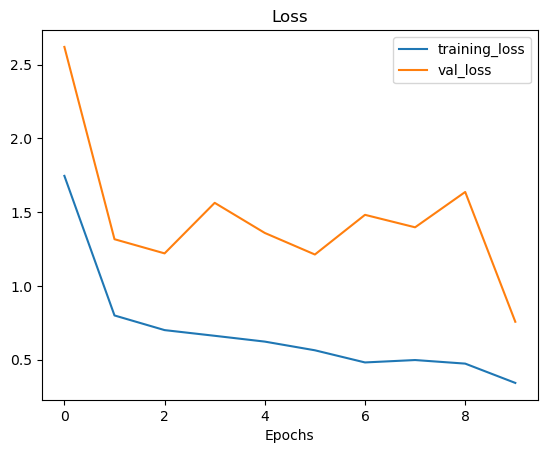

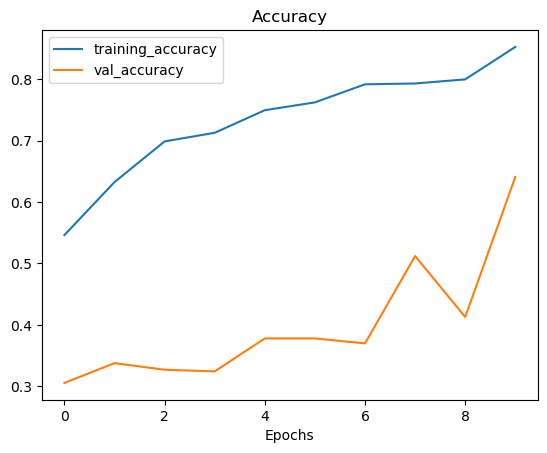

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [15]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 12 predictions: {pred[:12]}')

15/15 [==============================] - 11s 692ms/step
The first 12 predictions: ['plastic', 'plastic', 'plastic', 'white-glass', 'white-glass', 'white-glass', 'trash', 'plastic', 'white-glass', 'trash', 'white-glass', 'white-glass']


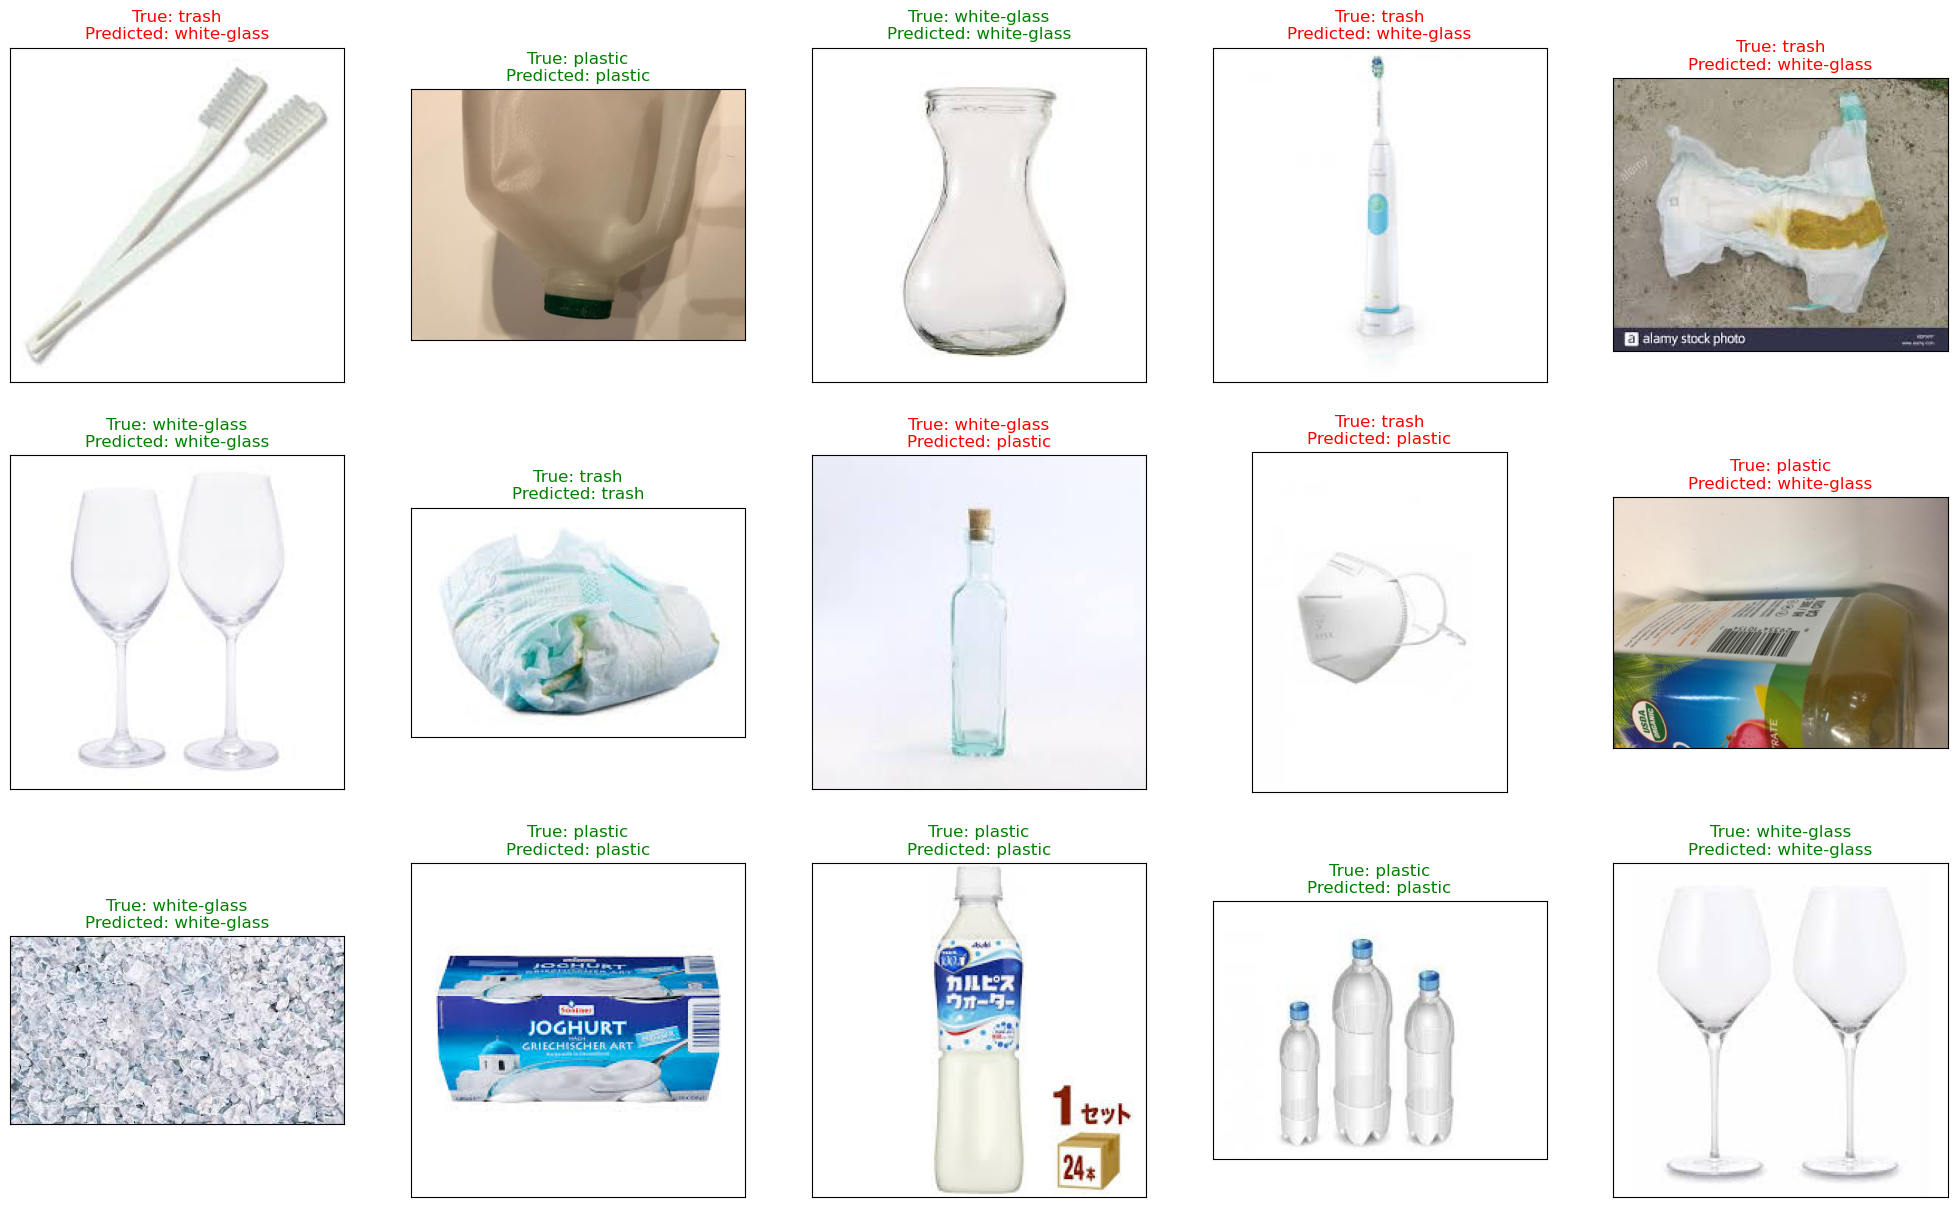

<Figure size 640x480 with 0 Axes>

In [16]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [17]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
plastic,0.579487,0.733766,0.647564,154.00000
trash,0.773723,0.683871,0.726027,155.00000
white-glass,0.654412,0.559748,0.603390,159.00000
accuracy,0.658120,0.658120,0.658120,0.65812
macro avg,0.669207,0.659129,0.658994,468.00000
weighted avg,0.669272,0.658120,0.658543,468.00000


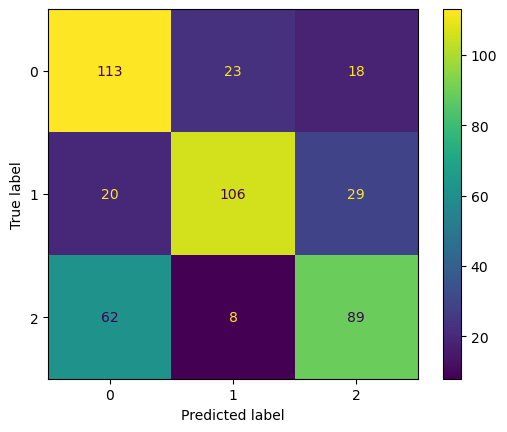

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()